In [5]:
import torch
from torch import optim, nn
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision


from mirrornet import MirrorNet
from dataset import ImageFolder

pretrain_directory = "/home/research/Datasets/NormalNet/dataset"


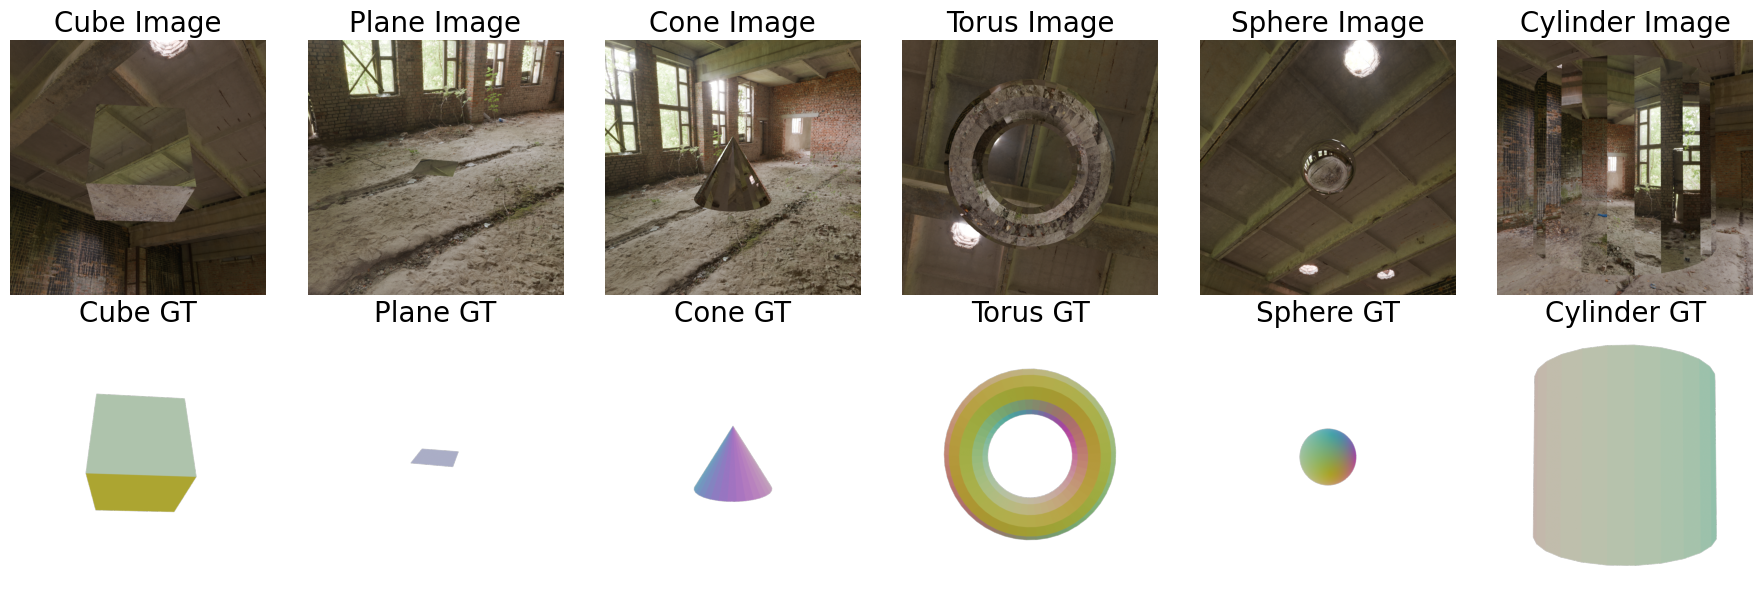

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def load_and_display_selected_images(image_dir, prefixes, skip_prefix=['cone','cylinder'], skip_count=1, title_fontsize=14):
    """Load and display selected images with ground truth masks in a grid, based on given prefixes,
    skipping the first image of a certain prefix and adjusting title font size."""
    
    # Initialize the matplotlib figure with two rows and as many columns as there are prefixes
    num_images = len(prefixes)
    fig, axs = plt.subplots(2, num_images, figsize=(num_images * 3, 6))  # Adjust the size accordingly

    # Iterate over the list of prefixes
    for i, prefix in enumerate(prefixes):
        # Find image files that start with the current prefix and contain 'reflective'
        image_files = [f for f in os.listdir(image_dir) if f.startswith(prefix) and 'reflective' in f]
        image_files = sorted(image_files)
        
        # Skip the specified number of images for the given prefix
        if prefix in skip_prefix:
            image_files = image_files[skip_count:]

        # If no images are left after skipping, continue to the next prefix
        if not image_files:
            print(f"No images found for prefix '{prefix}' after skipping {skip_count}.")
            continue
        
        # Select the first image after skipping
        img_file = image_files[0]

        # Construct the corresponding ground truth file name
        gt_file = img_file.replace('reflective', 'normal')

        # Load images
        img_path = os.path.join(image_dir, img_file)
        gt_path = os.path.join(image_dir, gt_file)
        image = Image.open(img_path)
        ground_truth = Image.open(gt_path)

        # Display the reflective image
        axs[0, i].imshow(image)
        axs[0, i].set_title(f'{prefix.capitalize()} Image', fontsize=title_fontsize)
        axs[0, i].axis('off')

        # Display the ground truth mask
        axs[1, i].imshow(ground_truth, cmap='gray')
        axs[1, i].set_title(f'{prefix.capitalize()} GT', fontsize=title_fontsize)
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# List of prefixes to fetch and display
prefixes = ['cube', 'plane', 'cone', 'torus', 'sphere', 'cylinder']

# Call the function with the directory path and the list of prefixes
load_and_display_selected_images(pretrain_directory, prefixes, title_fontsize=20)


In [5]:
# Configuration
data_root = "/home/research/Datasets/NormalNet/MSD/train"  # Update this path
ckpt_path = "./ckpt"
exp_name = "MirrorNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
batch_size = 30
learning_rate = 0.001
DIM = 384

args = {"snapshot": "160", "scale": 384, "crf": True}
# Transforms
img_transform = transforms.Compose(
    [
        transforms.Resize((args["scale"], args["scale"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

target_transform = transforms.Compose(
    [transforms.Resize((384, 384), interpolation=Image.NEAREST), transforms.ToTensor()]
)

# Dataset and DataLoader for finetuning
train_dataset = ImageFolder(
    root=data_root, img_transform=img_transform, target_transform=target_transform
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

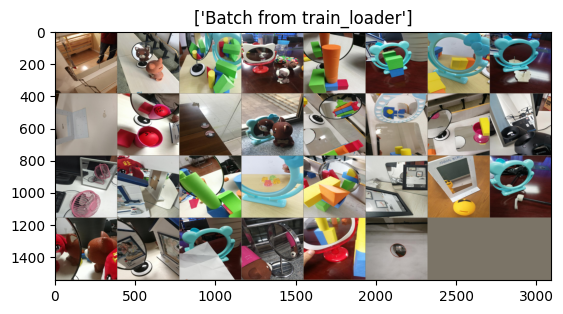

In [6]:
# Visualization function
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[f'Batch from train_loader'])

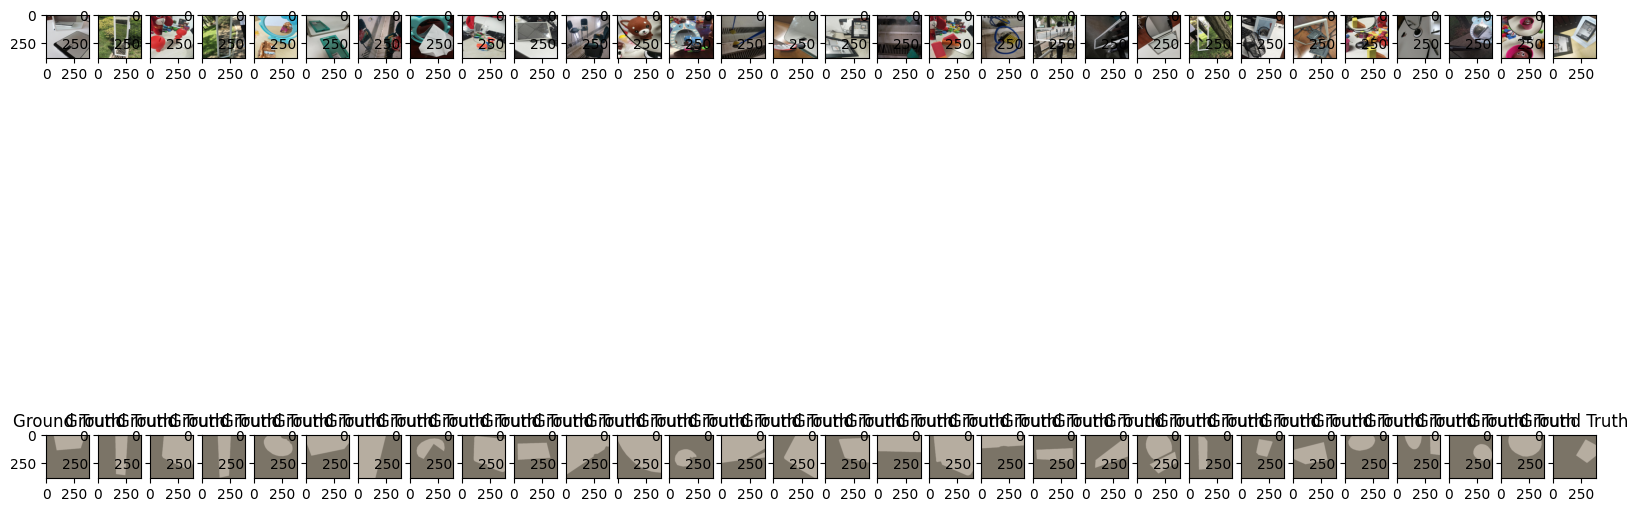

In [7]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)

# # Function to visualize a batch of input images and their corresponding ground truths
# def show_images_with_masks(images, masks):
#     """Show images with masks in a grid."""
#     plt.figure(figsize=(20, 10))
#     for i in range(images.size(0)):
#         plt.subplot(2, batch_size, i + 1)
#         imshow(images[i])
        
#         plt.subplot(2, batch_size, batch_size + i + 1)
#         imshow(masks[i], title="Ground Truth")
#     plt.show()

# # Get a batch of training data
# inputs, masks = next(iter(train_loader))

# # Make a grid from batch for inputs. For masks, we'll just use the batch as is.
# inputs_grid = torchvision.utils.make_grid(inputs)

# # Assuming masks are single-channel (1, H, W) and need to be repeated to (3, H, W) for visualization
# masks_repeated = masks.repeat(1, 3, 1, 1)  # Repeat the mask channel 3 times to make it RGB
# masks_grid = torchvision.utils.make_grid(masks_repeated)

# show_images_with_masks(inputs, masks_repeated)

In [19]:
import torch
from torch import optim, nn
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
from tqdm import tqdm

from mirrornet import MirrorNet
from dataset import ImageFolder
from image_dataset import ImageDataset
import lovasz_losses as L

# Configuration
pretrain_directory = "/home/research/Datasets/NormalNet/dataset"
data_root = "/path/to/your/dataset"
ckpt_path = "./ckpt"
exp_name = "MirrorNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
batch_size = 5
learning_rate = 0.001
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


# Transforms
img_transform = transforms.Compose(
    [
        transforms.Resize((args["scale"], args["scale"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
target_transform = transforms.Compose(
    [transforms.Resize((384, 384), interpolation=Image.NEAREST), transforms.ToTensor()]
)

pretrain_dataset = ImageDataset(
    directory=pretrain_directory,
    # mod="binary",
    # transform=img_transform,
    shape=["cube", "plane"],
)
pretrain_loader = DataLoader(
    dataset=pretrain_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None, save_path=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Assuming pretrain_loader is defined and is a PyTorch DataLoader
inputs, classes = next(iter(pretrain_loader))

# Make a grid from batch and show it together with the labels
out = torchvision.utils.make_grid(inputs)
class_labels = [class_names[x] for x in classes]  # Assuming class_names is defined

# Call imshow
plt.figure(figsize=(batch_size * 2, 2))  # Adjust the size accordingly
imshow(out, title=class_labels, save_path='/path/to/save/image.png')

plt.show()  # Display the figure


In [ ]:
print(len(pretrain_dataset))

10639
